# Mujoco basics
This file mainly follows the Mujoco Tutorial of https://github.com/google-deepmind/mujoco to make myself familiar with Mujoco simulations

In [1]:
import os

# 选项 A: 如果你有 NVIDIA 显卡，尝试使用 EGL (推荐，速度快)
# os.environ['MUJOCO_GL'] = 'egl'

# 选项 B: 如果选项 A 仍然报错或花屏，改用 OSMesa (软件渲染，兼容性最强，但慢一点)
os.environ['MUJOCO_GL'] = 'osmesa'

import mujoco  # 导入 MuJoCo 物理引擎库
import mediapy as media  # 导入 mediapy 并命名为 media，用于图片/视频展示
import matplotlib.pyplot as plt  # 导入 matplotlib 的 pyplot 模块用于绘图
import numpy as np  # 导入 NumPy 进行数值计算

import time  # 导入 time 模块，用于计时或延迟
import itertools  # 导入 itertools 模块，提供迭代器工具

In [2]:
xml = """  # 定义一个多行字符串，描述 MuJoCo 场景的 MJCF XML
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)  # 从 XML 字符串编译生成 MjModel 模型对象

The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
  - We define two geoms in the world named `red_box` and `green_sphere`.
  - **Question:** The `red_box` has no position, the `green_sphere` has no type, why is that?
    - **Answer:** MJCF attributes have *default values*. The default position is `0 0 0`, the default geom type is `sphere`. The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

The `from_xml_string()` method invokes the model compiler, which creates a binary `mjModel` instance.

## mjModel

MuJoCo's `mjModel`, contains the *model description*, i.e., all quantities which *do not change over time*. The complete description of `mjModel` can be found at the end of the header file [`mjmodel.h`](https://github.com/deepmind/mujoco/blob/main/include/mujoco/mjmodel.h). Note that the header files contain short, useful inline comments, describing each field.

Examples of quantities that can be found in `mjModel` are `ngeom`, the number of geoms in the scene and `geom_rgba`, their respective colors:

In [3]:
model.ngeom  # 查看模型中几何体（geom）的数量

2

In [4]:
model.geom_rgba  # 查看所有几何体的 RGBA 颜色数组

array([[1., 0., 0., 1.],
       [0., 1., 0., 1.]], dtype=float32)

## Named access

The MuJoCo Python bindings provide convenient [accessors](https://mujoco.readthedocs.io/en/latest/python.html#named-access) using names. Calling the `model.geom()` accessor without a name string generates a convenient error that tells us what the valid names are.

In [6]:
try:
  model.geom()  # 不传 name 调用 accessor，触发错误以查看合法名称
except KeyError as e:  # 捕获 KeyError 以读取提示信息
  print(e)  # 打印错误内容

"Invalid name ''. Valid names: ['green_sphere', 'red_box']"


Calling the named accessor without specifying a property will tell us what all the valid properties are:

In [7]:
model.geom('green_sphere')  # 按名称获取 green_sphere 几何体的所有属性

<_MjModelGeomViews
  bodyid: array([0], dtype=int32)
  conaffinity: array([1], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([1], dtype=int32)
  dataid: array([-1], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([0], dtype=int32)
  id: 1
  margin: array([0.])
  matid: array([-1], dtype=int32)
  name: 'green_sphere'
  pos: array([0.2, 0.2, 0.2])
  priority: array([0], dtype=int32)
  quat: array([1., 0., 0., 0.])
  rbound: array([0.1])
  rgba: array([0., 1., 0., 1.], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.1, 0. , 0. ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

Let's read the `green_sphere`'s rgba values:

In [8]:
model.geom('green_sphere').rgba  # 读取 green_sphere 的 RGBA 颜色值

array([0., 1., 0., 1.], dtype=float32)

This functionality is a convenience shortcut for MuJoCo's [`mj_name2id`](https://mujoco.readthedocs.io/en/latest/APIreference.html?highlight=mj_name2id#mj-name2id) function:

In [9]:
id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'green_sphere')  # 使用底层 API 获取 green_sphere 的 geom ID
model.geom_rgba[id, :]  # 通过索引访问对应 geom 的颜色数组

array([0., 1., 0., 1.], dtype=float32)

Similarly, the read-only `id` and `name` properties can be used to convert from id to name and back:

In [10]:
print('id of "green_sphere": ', model.geom('red_box').id)  # 读取 red_box 对应的 geom ID
print('name of geom 0: ', model.geom(0).name)  # 通过 ID 0 查询 geom 名称
print('name of body 0: ', model.body(0).name)  # 通过 ID 0 查询 body 名称

id of "green_sphere":  0
name of geom 0:  red_box
name of body 0:  world


Note that the 0th body is always the `world`. It cannot be renamed.

The `id` and `name` attributes are useful in Python comprehensions:

In [11]:
[model.geom(i).name for i in range(model.ngeom)]  # 遍历所有 geom ID，收集它们的名称列表

['red_box', 'green_sphere']

## mjData
`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

In [12]:
data = mujoco.MjData(model)  # 基于模型创建 mjData，用于保存状态与派生量

`mjData` also contains *functions of the state*, for example the Cartesian positions of objects in the world frame. The (x, y, z) positions of our two geoms are in `data.geom_xpos`:

In [13]:
print(data.geom_xpos)  # 输出当前每个 geom 在世界坐标系下的 (x, y, z) 位置

[[0. 0. 0.]
 [0. 0. 0.]]


Wait, why are both of our geoms at the origin? Didn't we offset the green sphere? The answer is that derived quantities in `mjData` need to be explicitly propagated. In our case, the minimal required function is [`mj_kinematics`](https://mujoco.readthedocs.io/en/latest/APIreference.html#mj-kinematics), which computes global Cartesian poses for all objects (excluding cameras and lights).

In [14]:
mujoco.mj_kinematics(model, data)  # 调用动力学函数刷新所有派生的空间位姿
print('raw access:\n', data.geom_xpos)  # 原始方式打印 geom 的坐标数组

# MjData also supports named access:
print('\nnamed access:\n', data.geom('green_sphere').xpos)  # 使用命名访问直接读取 green_sphere 的坐标

raw access:
 [[0.  0.  0. ]
 [0.2 0.2 0.2]]

named access:
 [0.2 0.2 0.2]


# Basic rendering, simulation, and animation

In order to render we'll need to instantiate a `Renderer` object and call its `render` method.

We'll also reload our model to make the colab's sections independent.


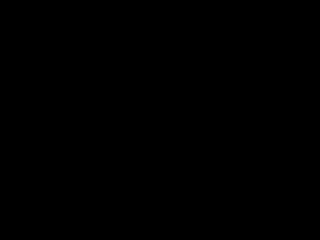

In [15]:
xml = """  # 定义包含光源与两个几何体的 MJCF 场景
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
#
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)  # 由 XML 字符串创建模型对象
data = mujoco.MjData(model)  # 基于模型初始化数据结构

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)  # 创建渲染器以生成图像
media.show_image(renderer.render())  # 渲染当前场景并显示图像


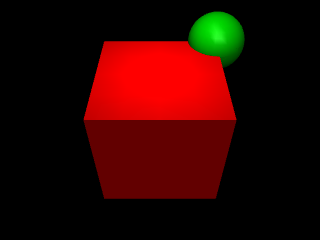

In [16]:
mujoco.mj_forward(model, data)  # 执行前向动力学，确保派生量更新
renderer.update_scene(data)  # 用最新数据更新渲染场景
media.show_image(renderer.render())  # 再次渲染并展示结果

Much better!

Note that all values in the `mjModel` instance are writable. While it's generally not recommended to do this but rather to change the values in the XML, because it's easy to make an invalid model, some values are safe to write into, for example colors:


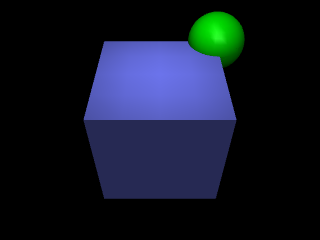

In [17]:
# Run this cell multiple times for different colors
model.geom('red_box').rgba[:3] = np.random.rand(3)  # 随机生成 RGB 颜色并写回 red_box 的前三个通道
renderer.update_scene(data)  # 更新渲染场景以应用新颜色
media.show_image(renderer.render())  # 渲染并显示颜色变化后的图像

# Simulation

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$.

Note that in the code block below we are *not* rendering after each call to `mj_step`. This is because the default timestep is 2ms, and we want a 60fps video, not 500fps.

In [18]:
duration = 3.8  # (seconds)  # 设置模拟持续时间为 3.8 秒
framerate = 60  # (Hz)  # 指定目标视频帧率 60Hz

# Simulate and display video.
frames = []  # 准备一个列表存放渲染帧
mujoco.mj_resetData(model, data)  # Reset state and time.  # 重置模型状态与时间
while data.time < duration:  # 循环直到模拟时间达到设定时长
  mujoco.mj_step(model, data)  # 推进一次物理仿真步
  if len(frames) < data.time * framerate:  # 控制采样频率，接近目标帧率
    renderer.update_scene(data)  # 用最新状态刷新渲染场景
    pixels = renderer.render()  # 渲染出一帧图像
    frames.append(pixels)  # 将图像保存到帧列表
media.show_video(frames, fps=framerate)  # 以指定帧率播放生成的视频

Hmmm, the video is playing, but nothing is moving, why is that?

This is because this model has no [degrees of freedom](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics)) (DoFs). The things that move (and which have inertia) are called *bodies*. We add DoFs by adding *joints* to bodies, specifying how they can move with respect to their parents. Let's make a new body that contains our geoms, add a hinge joint and re-render, while visualizing the joint axis using the visualization option object `MjvOption`.

In [19]:
try:
  del renderer  # 如果之前存在渲染器，先删除释放资源
except:  # 若删除失败或不存在渲染器
  pass  # 忽略异常

xml = """  # 定义带有 body、light 和 hinge 关节的 MJCF 场景
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

model = mujoco.MjModel.from_xml_string(xml)  # 根据新的 XML 创建模型
data = mujoco.MjData(model)  # 创建对应的状态数据
renderer = mujoco.Renderer(model)  # 初始化渲染器

# enable joint visualization option:
scene_option = mujoco.MjvOption()  # 实例化可视化选项
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True  # 打开关节可视化标志

duration = 8  # (seconds)  # 设定模拟时长
framerate = 60  # (Hz)  # 目标输出帧率

frames = []  # 保存渲染帧
mujoco.mj_resetData(model, data)  # 重置状态
while data.time < duration:  # 在整个模拟时长内循环
  mujoco.mj_step(model, data)  # 推进一步模拟
  if len(frames) < data.time * framerate:  # 根据帧率采样
    renderer.update_scene(data, scene_option=scene_option)  # 更新场景并显示关节选项
    pixels = renderer.render()  # 渲染当前帧
    frames.append(pixels)  # 存储帧

# Simulate and display video.
media.show_video(frames, fps=framerate)  # 以指定帧率播放模拟结果

Note that we rotated the box_and_sphere body by 30° around the Z (vertical) axis, with the directive euler="0 0 -30". This was made to emphasize that the poses of elements in the kinematic tree are always with respect to their parent body, so our two geoms were also rotated by this transformation.

Physics options live in mjModel.opt, for example the timestep:

In [101]:
model.opt.timestep  # 读取当前模型的物理模拟时间步长

0.002

Let's flip gravity and re-render:

In [20]:
print('default gravity', model.opt.gravity)  # 打印默认重力向量
model.opt.gravity = (0, 0, 10)  # 将重力翻转为指向上方
print('flipped gravity', model.opt.gravity)  # 再次打印验证修改

frames = []  # 存储渲染帧
mujoco.mj_resetData(model, data)  # 重置状态以应用新重力
while data.time < duration:  # 在同样的模拟时长内循环
  mujoco.mj_step(model, data)  # 推进模拟
  if len(frames) < data.time * framerate:  # 以目标帧率取样
    renderer.update_scene(data, scene_option=scene_option)  # 更新场景渲染
    pixels = renderer.render()  # 渲染帧
    frames.append(pixels)  # 保存帧

media.show_video(frames, fps=60)  # 以 60fps 播放视频

default gravity [ 0.    0.   -9.81]
flipped gravity [ 0.  0. 10.]


### Understanding Degrees of Freedom

In the real world, all rigid objects have 6 degrees-of-freedom: 3 translations and 3 rotations. Real-world joints act as constraints, removing relative degrees-of-freedom from bodies connected by joints. Some physics simulation software use this representation which is known as the "Cartesian" or "subtractive" representation, but it is inefficient. MuJoCo uses a representation known as the "Lagrangian", "generalized" or "additive" representation, whereby objects have no degrees of freedom unless explicitly added using joints.

Our model, which has a single hinge joint, has one degree of freedom, and the entire state is defined by this joint's angle and angular velocity. These are the system's generalized position and velocity.

In [ ]:
print('Total number of DoFs in the model:', model.nv)  # 输出模型的自由度数量
print('Generalized positions:', data.qpos)  # 打印当前广义位置
print('Generalized velocities:', data.qvel)  # 打印当前广义速度

Total number of DoFs in the model: 1
Generalized positions: [1.39239139]
Generalized velocities: [-3.79045972]


MuJoCo's use of generalized coordinates is the reason that calling a function (e.g. mj_forward) is required before rendering or reading the global poses of objects – Cartesian positions are derived from the generalized positions and need to be explicitly computed.

# Example: Simulating free bodies with the self-inverting "tippe-top"

A free body is a body with a [free joint](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint) having 6 DoFs, i.e., 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:


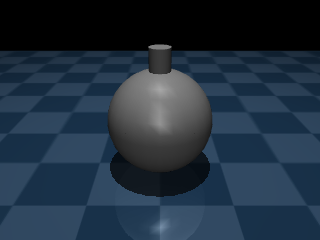

In [21]:
try:
  del renderer  # 若先前存在渲染器实例则删除，避免复用旧资源
except:
  pass  # 如果删除失败（变量不存在等），忽略异常继续执行

tippe_top = """  # 定义一个包含 tippe-top 模型的 MJCF 字符串
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)  # 将 MJCF 文本编译成 MuJoCo 模型
renderer = mujoco.Renderer(model)  # 创建渲染器以便可视化该模型
data = mujoco.MjData(model)  # 初始化与模型对应的动态数据结构
mujoco.mj_forward(model, data)  # 执行一次前向计算以填充派生量
renderer.update_scene(data, camera="closeup")  # 使用定义的 closeup 相机更新场景
media.show_image(renderer.render())  # 渲染出图像并显示

Note several new features of this model definition:
1. A 6-DoF free joint is added with the `<freejoint/>` clause.
2. We use the `<option/>` clause to set the integrator to the 4th order [Runge Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). Runge-Kutta has a higher rate of convergence than the default Euler integrator, which in many cases increases the accuracy at a given timestep size.
3. We define the floor's grid material inside the `<asset/>` clause and reference it in the `"floor"` geom.
4. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is (counter-intuitively) required for the flipping behavior to occur.
5. We save our initial spinning state as a *keyframe*. It has a high rotational velocity around the Z-axis, but is not perfectly oriented with the world, which introduces the symmetry-breaking required for the flipping.
6. We define a `<camera>` in our model, and then render from it using the `camera` argument to `update_scene()`.
Let us examine the state:


In [22]:
print('positions', data.qpos)  # 输出当前广义位置向量（包含平移与四元数）
print('velocities', data.qvel)  # 输出当前广义速度向量（每个自由度的速度）

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


The velocities are easy to interpret, 6 zeros, one for each DoF. What about the length 7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a unit quaternion. 3D orientations are represented with 4 numbers while angular velocities are 3 numbers. For more information see the Wikipedia article on quaternions and spatial rotation.

Let's make a video:

In [25]:
duration = 10    # (seconds)  # 设置模拟时长为 7 秒
framerate = 60  # (Hz)  # 指定目标视频帧率为 60Hz

# Simulate and display video.
frames = []  # 用于存储渲染得到的图像帧
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0  # 将状态重置到第 0 个关键帧
while data.time < duration:  # 在模拟时间未达到目标时持续迭代
  mujoco.mj_step(model, data)  # 推进一步动力学仿真
  if len(frames) < data.time * framerate:  # 根据当前时间决定是否采样一帧，保证帧率
    renderer.update_scene(data, "closeup")  # 使用 closeup 相机更新渲染场景
    pixels = renderer.render()  # 渲染出当前帧像素
    frames.append(pixels)  # 将像素帧加入列表

media.show_video(frames, fps=framerate)  # 以设定帧率播放生成的视频

### Measuring values from `mjData`
As mentioned above, the `mjData` structure contains the dynamic variables and intermediate results produced by the simulation which are *expected to change* on each timestep. Below we simulate for 2000 timesteps and plot the angular velocity of the top and height of the stem as a function of time.

In [ ]:
data.body(1)  # 通过命名访问获取 ID 为 1 的刚体属性视图

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([1.27362839e-05, 1.27373044e-05, 1.28282279e-05, 1.02176642e-09,
       7.64805200e-09, 1.23679721e-08, 1.92466076e-19, 0.00000000e+00,
       0.00000000e+00, 5.54745694e-02])
  crb: array([1.27362839e-05, 1.27373044e-05, 1.28282279e-05, 1.02176642e-09,
       7.64805200e-09, 1.23679721e-08, 1.92466076e-19, 0.00000000e+00,
       0.00000000e+00, 5.54745694e-02])
  cvel: array([ 3.93534372e-01,  2.89567118e+00,  8.17926078e+01,  2.52382030e-02,
        2.54512404e-02, -1.25879503e-03])
  id: 1
  name: 'top'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([ 0.02377079, -0.02368274,  0.03328745])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([-0.08161319, -0.50814533,  0.85739583, -0.13197997,  0.85819974,
        0.49605896, -0.98788692, -0.07267412, -0.13710543])

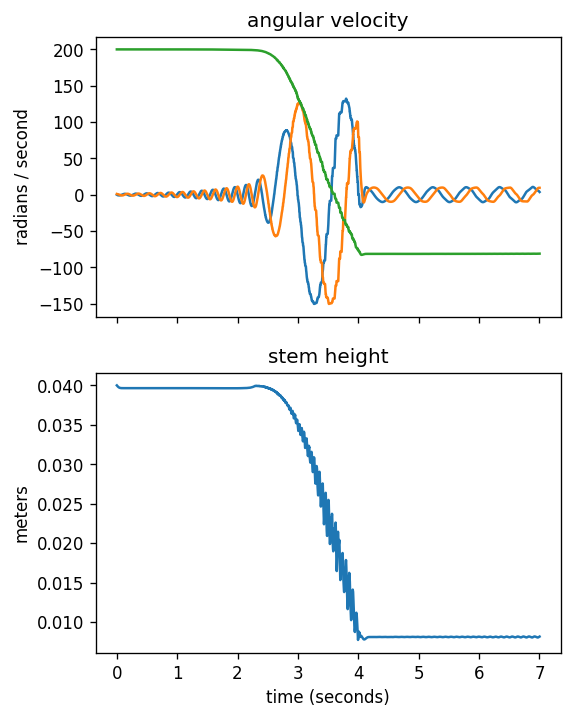

In [ ]:
timevals = []  # 保存每次采样的时间戳
angular_velocity = []  # 保存陀螺的角速度向量
stem_height = []  # 保存陀螺杆顶部的高度

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)  # 重置到 keyframe 0，确保初始条件一致
while data.time < duration:  # 在指定时长内运行模拟
  mujoco.mj_step(model, data)  # 推进一步动力学
  timevals.append(data.time)  # 记录当前时间
  angular_velocity.append(data.qvel[3:6].copy())  # 保存躯干的角速度分量
  stem_height.append(data.geom_xpos[2,2])  # 记录杆顶 geom 的 z 坐标

dpi = 120  # 图像分辨率（每英寸点数）
width = 600  # 图像宽度像素
height = 800  # 图像高度像素
figsize = (width / dpi, height / dpi)  # Matplotlib figsize 以英寸为单位
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)  # 创建上下两个共享 x 轴的子图

ax[0].plot(timevals, angular_velocity)  # 在上方子图绘制角速度曲线
ax[0].set_title('angular velocity')  # 设置标题
ax[0].set_ylabel('radians / second')  # 设置 y 轴单位

ax[1].plot(timevals, stem_height)  # 下方子图绘制杆顶高度
ax[1].set_xlabel('time (seconds)')  # 设置 x 轴标签
ax[1].set_ylabel('meters')  # 设置 y 轴标签
_ = ax[1].set_title('stem height')  # 设置下方子图标题

# Example: A chaotic pendulum
Below is a model of a chaotic pendulum, similar to [this one](https://www.exploratorium.edu/exhibits/chaotic-pendulum) in the San Francisco Exploratorium.


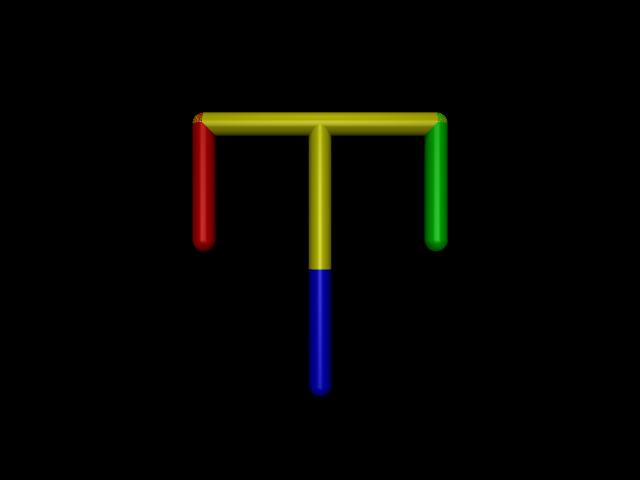

In [ ]:
try:
  del renderer  # 如果已有渲染器实例，先删除以防干扰
except:
  pass  # 若删除失败或不存在渲染器，则忽略异常

chaotic_pendulum = """  # 定义混沌摆的 MJCF 模型描述
<mujoco>
  <option timestep=".001">
    <flag energy="enable" contact="disable"/>
  </option>

  <default>
    <joint type="hinge" axis="0 -1 0"/>
    <geom type="capsule" size=".02"/>
  </default>

  <worldbody>
    <light pos="0 -.4 1"/>
    <camera name="fixed" pos="0 -1 0" xyaxes="1 0 0 0 0 1"/>
    <body name="0" pos="0 0 .2">
      <joint name="root"/>
      <geom fromto="-.2 0 0 .2 0 0" rgba="1 1 0 1"/>
      <geom fromto="0 0 0 0 0 -.25" rgba="1 1 0 1"/>
      <body name="1" pos="-.2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="1 0 0 1"/>
      </body>
      <body name="2" pos=".2 0 0">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 1 0 1"/>
      </body>
      <body name="3" pos="0 0 -.25">
        <joint/>
        <geom fromto="0 0 0 0 0 -.2" rgba="0 0 1 1"/>
      </body>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(chaotic_pendulum)  # 解析 MJCF 字符串构建模型
renderer = mujoco.Renderer(model, 480, 640)  # 创建指定分辨率的渲染器
data = mujoco.MjData(model)  # 初始化数据结构
mujoco.mj_forward(model, data)  # 前向计算以填充派生量
renderer.update_scene(data, camera="fixed")  # 使用固定相机更新场景
media.show_image(renderer.render())  # 渲染并展示当前帧

## Timing
Let's see a video of it in action while we time the components:

In [ ]:
try:
  del renderer  # 若已有渲染器实例则先删除
except:
  pass  # 删除失败时忽略异常

# setup
n_seconds = 6  # 将模拟视频时长设为 6 秒
framerate = 30  # Hz  # 指定输出视频帧率为 30Hz
n_frames = int(n_seconds * framerate)  # 计算需要渲染的总帧数
frames = []  # 用于保存每一帧图像
renderer = mujoco.Renderer(model, 240, 320)  # 构建 240x320 分辨率的渲染器


# set initial state
mujoco.mj_resetData(model, data)  # 重置模型状态
data.joint('root').qvel = 10  # 给根关节一个初始角速度


# simulate and record frames
frame = 0  # 当前渲染帧的缓存
sim_time = 0  # 记录模拟所耗时间
render_time = 0  # 记录渲染所耗时间
n_steps = 0  # 统计实际模拟步数
for i in range(n_frames):  # 遍历每一帧
  while data.time * framerate < i:  # 若当前模拟时间不足以支撑该帧，则继续推进模拟
    tic = time.time()  # 记录模拟开始时间
    mujoco.mj_step(model, data)  # 推进一步物理仿真
    sim_time += time.time() - tic  # 累加本次模拟耗时
    n_steps += 1  # 增加步数计数
  tic = time.time()  # 开始记录渲染耗时
  renderer.update_scene(data, "fixed")  # 使用固定相机更新场景
  frame = renderer.render()  # 渲染当前帧图像
  render_time += time.time() - tic  # 累加渲染耗时
  frames.append(frame)  # 将帧加入列表

# print timing and play video
step_time = 1e6*sim_time/n_steps  # 计算平均每步模拟耗时（微秒）
step_fps = n_steps/sim_time  # 计算模拟步频（Hz）
print(f'simulation: {step_time:5.3g} μs/step  ({step_fps:5.0f}Hz)')  # 输出模拟性能
frame_time = 1e6*render_time/n_frames  # 平均每帧渲染耗时（微秒）
frame_fps = n_frames/render_time  # 渲染帧率（Hz）
print(f'rendering:  {frame_time:5.3g} μs/frame ({frame_fps:5.0f}Hz)')  # 输出渲染性能
print('\n')  # 打印空行

# show video
media.show_video(frames, fps=framerate)  # 按 30fps 播放生成的视频

simulation:  2.39 μs/step  (417890Hz)
rendering:  1.87e+03 μs/frame (  535Hz)




Note that rendering is **much** slower than the simulated physics.


## Chaos
This is a [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) system (small pertubations in initial conditions accumulate quickly):

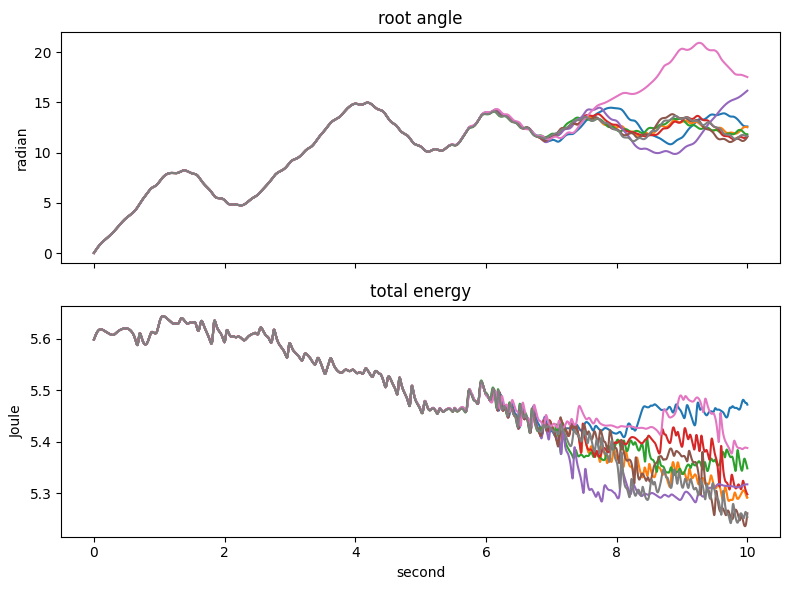

In [ ]:
PERTURBATION = 1e-7  # 初始速度的微小扰动幅度
SIM_DURATION = 10 # seconds  # 每次模拟的持续时间（秒）
NUM_REPEATS = 8  # 重复模拟的次数

# preallocate
n_steps = int(SIM_DURATION / model.opt.timestep)  # 根据时间步长计算每次模拟的步数
sim_time = np.zeros(n_steps)  # 存储每一步对应的时间
angle = np.zeros(n_steps)  # 存储根关节角度
energy = np.zeros(n_steps)  # 存储系统能量

# prepare plotting axes
_, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)  # 创建上下两个共享 x 轴的子图

# simulate NUM_REPEATS times with slightly different initial conditions
for _ in range(NUM_REPEATS):  # 循环多次，每次初始条件略有不同
  # initialize
  mujoco.mj_resetData(model, data)  # 重置模型状态
  data.qvel[0] = 10 # root joint velocity  # 设定根关节初始角速度
  # perturb initial velocities
  data.qvel[:] += PERTURBATION * np.random.randn(model.nv)  # 在所有速度上施加随机扰动

  # simulate
  for i in range(n_steps):  # 逐步推进模拟
    mujoco.mj_step(model, data)  # 执行一次仿真步
    sim_time[i] = data.time  # 记录当前时间
    angle[i] = data.joint('root').qpos  # 保存根关节角度
    energy[i] = data.energy[0] + data.energy[1]  # 记录动能与势能之和

  # plot
  ax[0].plot(sim_time, angle)  # 绘制角度随时间变化曲线
  ax[1].plot(sim_time, energy)  # 绘制能量随时间变化曲线

# finalize plot
ax[0].set_title('root angle')  # 设置角度图标题
ax[0].set_ylabel('radian')  # 角度图 y 轴单位
ax[1].set_title('total energy')  # 设置能量图标题
ax[1].set_ylabel('Joule')  # 能量单位
ax[1].set_xlabel('second')  # 公共 x 轴单位
plt.tight_layout()  # 调整布局避免重叠

## Timestep and accuracy
**Question:** Why is the energy varying at all? There is no friction or damping, this system should conserve energy.

**Answer:** Because of the discretization of time.

If we decrease the timestep we'll get better accuracy and better energy conservation:

1000 steps at dt = 10ms
3162 steps at dt = 3.2ms
10000 steps at dt =  1ms
31622 steps at dt = 0.32ms
100000 steps at dt = 0.1ms


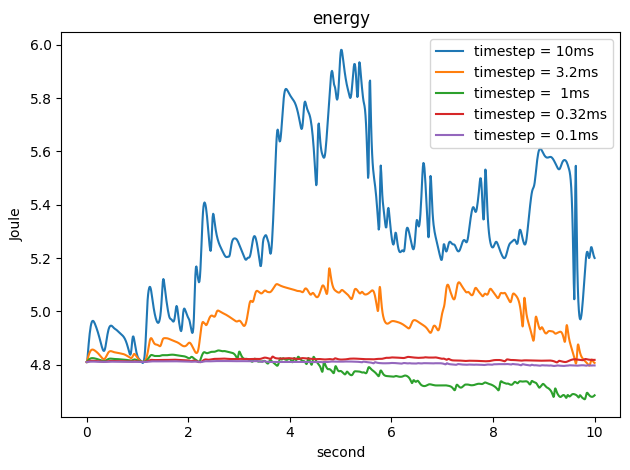

In [ ]:
SIM_DURATION = 10 # (seconds)  # 每次实验的总模拟时长
TIMESTEPS = np.power(10, np.linspace(-2, -4, 5))  # 生成多个不同数量级的时间步长

# prepare plotting axes
_, ax = plt.subplots(1, 1)  # 创建单个子图

for dt in TIMESTEPS:  # 遍历每个候选时间步长
   # set timestep, print
  model.opt.timestep = dt  # 将模型时间步设为当前值

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)  # 根据新的 dt 计算需要的步数
  sim_time = np.zeros(n_steps)  # 分配时间数组
  energy = np.zeros(n_steps)  # 分配能量数组

  # initialize
  mujoco.mj_resetData(model, data)  # 重置状态
  data.qvel[0] = 9 # root joint velocity  # 设定根关节初始角速度

  # simulate
  print('{} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))  # 打印本次实验配置
  for i in range(n_steps):  # 逐步仿真
    mujoco.mj_step(model, data)  # 执行一次仿真步
    sim_time[i] = data.time  # 记录时间
    energy[i] = data.energy[0] + data.energy[1]  # 记录能量

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))  # 绘制能量曲线并标注标签

# finalize plot
ax.set_title('energy')  # 设置图表标题
ax.set_ylabel('Joule')  # y 轴单位
ax.set_xlabel('second')  # x 轴单位
ax.legend(frameon=True);  # 显示图例
plt.tight_layout()  # 调整布局

## Timestep and divergence
When we increase the time step, the simulation quickly diverges:

simulating 1000 steps at dt = 10ms

stopped due to divergence (mjWARN_BADQACC) at timestep 385.

simulating 825 steps at dt = 12ms

stopped due to divergence (mjWARN_BADQACC) at timestep 322.

simulating 681 steps at dt = 15ms

stopped due to divergence (mjWARN_BADQACC) at timestep 166.

simulating 562 steps at dt = 18ms

stopped due to divergence (mjWARN_BADQACC) at timestep 105.

simulating 464 steps at dt = 22ms

stopped due to divergence (mjWARN_BADQACC) at timestep 84.

simulating 383 steps at dt = 26ms

stopped due to divergence (mjWARN_BADQACC) at timestep 61.

simulating 316 steps at dt = 32ms

stopped due to divergence (mjWARN_BADQACC) at timestep 45.



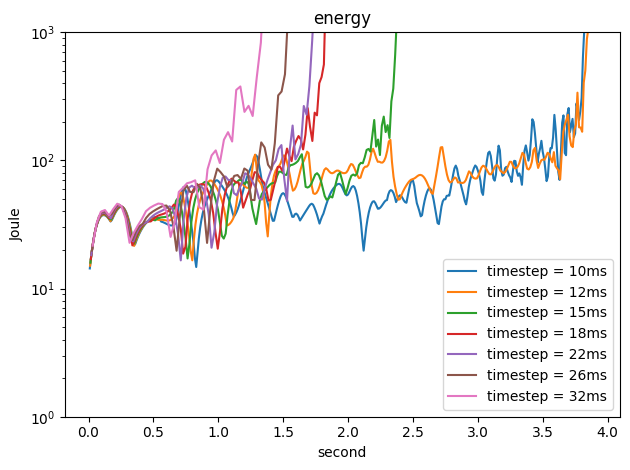

In [ ]:
SIM_DURATION = 10 # (seconds)  # 每次测试的总模拟时长
TIMESTEPS = np.power(10, np.linspace(-2, -1.5, 7))  # 生成一系列较大的时间步长

# get plotting axes
ax = plt.gca()  # 获取当前坐标轴用于绘图

for dt in TIMESTEPS:  # 遍历每个时间步
  # set timestep
  model.opt.timestep = dt  # 设置模型时间步

  # allocate
  n_steps = int(SIM_DURATION / model.opt.timestep)  # 根据 dt 计算需要的步数
  sim_time = np.zeros(n_steps)  # 预分配时间数组
  energy = np.zeros(n_steps) * np.nan  # 初始化能量数组并填充 NaN
  speed = np.zeros(n_steps) * np.nan  # 初始化速度数组并填充 NaN

  # initialize
  mujoco.mj_resetData(model, data)  # 重置模型状态
  data.qvel[0] = 11 # set root joint velocity  # 设置根关节初始角速度

  # simulate
  print('simulating {} steps at dt = {:2.2g}ms'.format(n_steps, 1000*dt))  # 打印本次设置
  for i in range(n_steps):  # 逐步仿真
    mujoco.mj_step(model, data)  # 执行模拟步
    if data.warning.number.any():  # 若出现警告
      warning_index = np.nonzero(data.warning.number)[0][0]  # 找到第一个警告索引
      warning = mujoco.mjtWarning(warning_index).name  # 转成警告名称
      print(f'stopped due to divergence ({warning}) at timestep {i}.\n')  # 输出停止信息
      break  # 终止当前时间步循环
    sim_time[i] = data.time  # 记录仿真时间
    energy[i] = sum(abs(data.qvel))  # 以速度的绝对值和作为能量指标
    speed[i] = np.linalg.norm(data.qvel)  # 计算速度向量的范数

  # plot
  ax.plot(sim_time, energy, label='timestep = {:2.2g}ms'.format(1000*dt))  # 绘制能量曲线
  ax.set_yscale('log')  # 使用对数刻度显示 y 轴


# finalize plot
ax.set_ybound(1, 1e3)  # 限制 y 轴范围
ax.set_title('energy')  # 设置图表标题
ax.set_ylabel('Joule')  # y 轴单位
ax.set_xlabel('second')  # x 轴单位
ax.legend(frameon=True, loc='lower right');  # 显示图例并放在右下角
plt.tight_layout()  # 调整布局

# Contacts

Let's go back to our box and sphere example and give it a free joint:


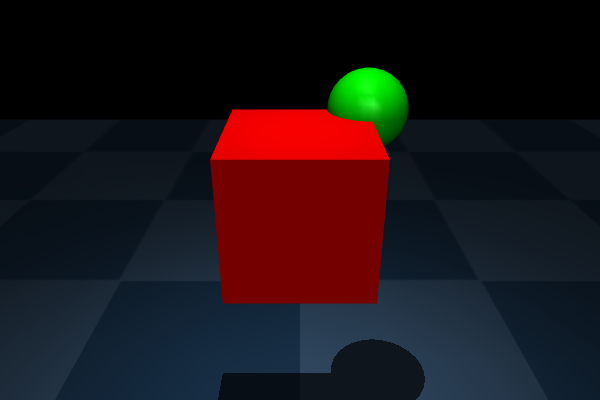

In [ ]:
try:
  del renderer  # 若有旧渲染器实例，先删除
except:
  pass  # 删除失败则忽略

free_body_MJCF = """  # 定义包含自由刚体的 MJCF 模型
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid" solimp=".99 .99 .01" solref=".001 1"/>
    <body name="box_and_sphere" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1"/>
      <geom name="green_sphere" size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)  # 解析 MJCF 创建模型
renderer = mujoco.Renderer(model, 400, 600)  # 创建 400x600 的渲染器
data = mujoco.MjData(model)  # 初始化状态数据
mujoco.mj_forward(model, data)  # 执行前向计算，填充派生量
renderer.update_scene(data, "fixed")  # 使用固定相机更新场景
media.show_image(renderer.render())  # 渲染结果并显示

Let render this body rolling on the floor, in slow-motion, while visualizing contact points and forces:

In [ ]:
try:
  del renderer  # 若已有渲染器实例则移除
except:
  pass  # 忽略删除失败情况

n_frames = 200  # 共渲染 200 帧
height = 240  # 图像高度
width = 320  # 图像宽度
frames = []  # 存放帧的列表
renderer = mujoco.Renderer(model, height, width)  # 创建给定大小的渲染器

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()  # 创建渲染可视化选项
mujoco.mjv_defaultOption(options)  # 初始化为默认设置
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # 显示接触点
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True  # 显示接触力
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # 将刚体设为透明

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1  # 调整接触可视化宽度
model.vis.scale.contactheight = 0.03  # 调整接触高度
model.vis.scale.forcewidth = 0.05  # 调整力可视化宽度
model.vis.map.force = 0.3  # 调整力的颜色映射比例

# random initial rotational velocity:
mujoco.mj_resetData(model, data)  # 重置状态
data.qvel[3:6] = 5*np.random.randn(3)  # 给旋转速度分量随机初值

# simulate and render
for i in range(n_frames):  # 遍历每一帧
  while data.time < i/120.0: #1/4x real time  # 以 1/4 实时速度推进仿真
    mujoco.mj_step(model, data)  # 执行仿真步
  renderer.update_scene(data, "track", options)  # 用跟踪相机和可视化选项更新场景
  frame = renderer.render()  # 渲染图像
  frames.append(frame)  # 保存帧

# show video
media.show_video(frames, fps=30)  # 以 30fps 播放视频

## Analysis of contact forces

Let's rerun the above simulation (with a different random initial condition) and
plot some values related to the contacts

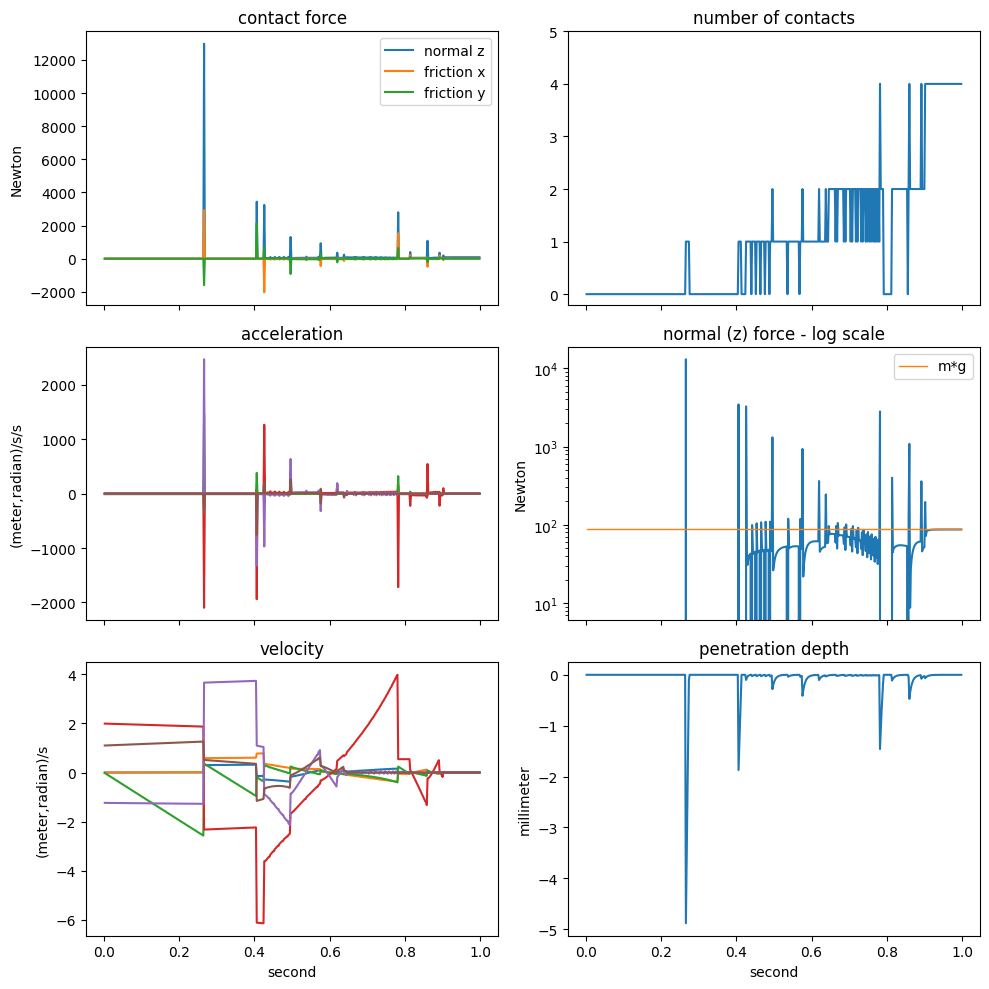

In [ ]:
n_steps = 499  # 仿真步数

# allocate
sim_time = np.zeros(n_steps)  # 存储时间
ncon = np.zeros(n_steps)  # 存储接触数量
force = np.zeros((n_steps,3))  # 存储合力（x,y,z）
velocity = np.zeros((n_steps, model.nv))  # 存储广义速度历史
penetration = np.zeros(n_steps)  # 存储最深穿透距离
acceleration = np.zeros((n_steps, model.nv))  # 存储广义加速度
forcetorque = np.zeros(6)  # 临时缓存 6 维力/力矩

# random initial rotational velocity:
mujoco.mj_resetData(model, data)  # 重置状态
data.qvel[3:6] = 2*np.random.randn(3)  # 给旋转速度随机初值

# simulate and save data
for i in range(n_steps):  # 逐步仿真
  mujoco.mj_step(model, data)  # 推进一步
  sim_time[i] = data.time  # 记录时间
  ncon[i] = data.ncon  # 当前接触数量
  velocity[i] = data.qvel[:]  # 保存速度
  acceleration[i] = data.qacc[:]  # 保存加速度
  # iterate over active contacts, save force and distance
  for j,c in enumerate(data.contact):  # 枚举每一个接触
    mujoco.mj_contactForce(model, data, j, forcetorque)  # 计算该接触力
    force[i] += forcetorque[0:3]  # 累加前三个分量（力）
    penetration[i] = min(penetration[i], c.dist)  # 记录最小接触距离（越小越深）
  # we could also do
  # force[i] += data.qfrc_constraint[0:3]
  # do you see why?

# plot
_, ax = plt.subplots(3, 2, sharex=True, figsize=(10, 10))  # 创建 3x2 子图，共享 x 轴

lines = ax[0,0].plot(sim_time, force)  # 绘制接触力三个分量
ax[0,0].set_title('contact force')  # 设置标题
ax[0,0].set_ylabel('Newton')  # y 轴单位
ax[0,0].legend(iter(lines), ('normal z', 'friction x', 'friction y'));  # 添加图例

ax[1,0].plot(sim_time, acceleration)  # 绘制每个自由度的加速度
ax[1,0].set_title('acceleration')  # 标题
ax[1,0].set_ylabel('(meter,radian)/s/s')  # 单位说明

ax[2,0].plot(sim_time, velocity)  # 绘制广义速度
ax[2,0].set_title('velocity')  # 标题
ax[2,0].set_ylabel('(meter,radian)/s')  # 单位
ax[2,0].set_xlabel('second')  # x 轴单位

ax[0,1].plot(sim_time, ncon)  # 绘制接触数量
ax[0,1].set_title('number of contacts')  # 标题
ax[0,1].set_yticks(range(6))  # 设定 y 轴刻度

ax[1,1].plot(sim_time, force[:,0])  # 绘制法向力
ax[1,1].set_yscale('log')  # y 轴使用对数刻度
ax[1,1].set_title('normal (z) force - log scale')  # 标题
ax[1,1].set_ylabel('Newton')  # 单位
z_gravity = -model.opt.gravity[2]  # 获取重力大小（正值）
mg = model.body("box_and_sphere").mass[0] * z_gravity  # 计算物体重量
mg_line = ax[1,1].plot(sim_time, np.ones(n_steps)*mg, label='m*g', linewidth=1)  # 画出 m*g 参考线
ax[1,1].legend()  # 显示图例

ax[2,1].plot(sim_time, 1000*penetration)  # 绘制穿透深度（mm）
ax[2,1].set_title('penetration depth')  # 标题
ax[2,1].set_ylabel('millimeter')  # 单位
ax[2,1].set_xlabel('second')  # x 轴单位

plt.tight_layout()  # 调整布局

## Friction

Let's see the effect of changing friction values

In [ ]:
try:
  del renderer  # 如果已有渲染器则删除
except:
  pass  # 忽略失败

MJCF = """  # 定义包含不同摩擦系数的场景
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="6 6"
     texuniform="true" reflectance=".2"/>
     <material name="wall" rgba='.5 .5 .5 1'/>
  </asset>

  <default>
    <geom type="box" size=".05 .05 .05" />
    <joint type="free"/>
  </default>

  <worldbody>
    <light name="light" pos="-.2 0 1"/>
    <geom name="ground" type="plane" size=".5 .5 10" material="grid"
     zaxis="-.3 0 1" friction=".1"/>
    <camera name="y" pos="-.1 -.6 .3" xyaxes="1 0 0 0 1 2"/>
    <body pos="0 0 .1">
      <joint/>
      <geom/>
    </body>
    <body pos="0 .2 .1">
      <joint/>
      <geom friction=".33"/>
    </body>
  </worldbody>

</mujoco>
"""
n_frames = 60  # 渲染 60 帧
height = 300  # 图像高度
width = 300  # 图像宽度
frames = []  # 帧缓存

# load
model = mujoco.MjModel.from_xml_string(MJCF)  # 加载模型
data = mujoco.MjData(model)  # 初始化数据
renderer = mujoco.Renderer(model, height, width)  # 创建渲染器

# simulate and render
mujoco.mj_resetData(model, data)  # 重置状态
for i in range(n_frames):  # 遍历帧
  while data.time < i/30.0:  # 以 30fps 的模拟节奏推进
    mujoco.mj_step(model, data)  # 仿真一步
  renderer.update_scene(data, "y")  # 用 y 相机更新场景
  frame = renderer.render()  # 渲染图像
  frames.append(frame)  # 保存帧
media.show_video(frames, fps=30)  # 以 30fps 播放

# Tendons, actuators and sensors


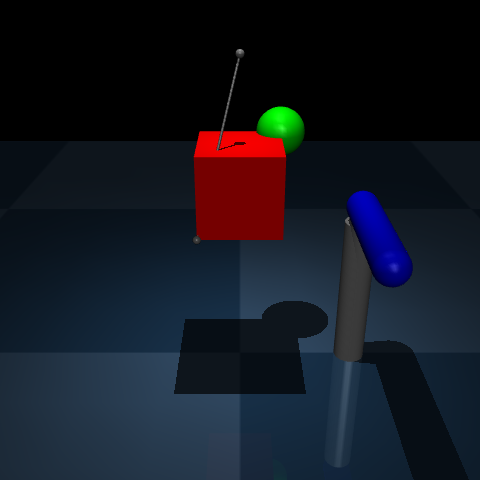

In [ ]:
try:
  del renderer  # 若旧渲染器存在则删除
except:
  pass  # 忽略异常

MJCF = """  # 定义包含肌腱、执行器和传感器的场景
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)  # 构建模型
renderer = mujoco.Renderer(model, 480, 480)  # 创建渲染器
data = mujoco.MjData(model)  # 初始化数据
mujoco.mj_forward(model, data)  # 前向计算
renderer.update_scene(data, "fixed")  # 使用固定相机更新场景
media.show_image(renderer.render())  # 渲染并显示

actuated bat and passive "piñata":

In [ ]:
try:
  del renderer  # 删除旧渲染器
except:
  pass  # 忽略异常

n_frames = 180  # 渲染帧数
height = 240  # 图像高度
width = 320  # 图像宽度
frames = []  # 帧缓存
fps = 60.0  # 目标帧率
times = []  # 记录传感时间戳
sensordata = []  # 记录传感器数据

renderer = mujoco.Renderer(model, height, width)  # 创建渲染器

# constant actuator signal
mujoco.mj_resetData(model, data)  # 重置状态
data.ctrl = 20  # 将执行器输入固定为常数

# simulate and render
for i in range(n_frames):  # 遍历每帧
  while data.time < i/fps:  # 保证模拟时间追上帧时间
    mujoco.mj_step(model, data)  # 推进一步
    times.append(data.time)  # 记录时间
    sensordata.append(data.sensor('accelerometer').data.copy())  # 保存 IMU 加速度
  renderer.update_scene(data, "fixed")  # 使用固定相机更新场景
  frame = renderer.render()  # 渲染图像
  frames.append(frame)  # 存储帧

media.show_video(frames, fps=fps)  # 播放记录下的视频

Let's plot the values measured by our accelerometer sensor:

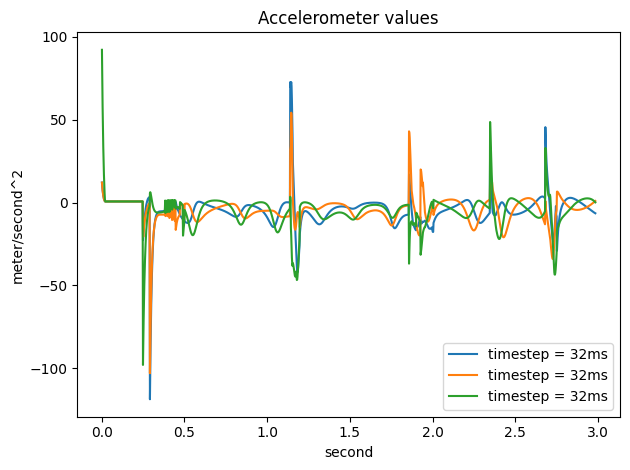

In [ ]:
ax = plt.gca()  # 获取当前坐标轴

ax.plot(np.asarray(times), np.asarray(sensordata), label='timestep = {:2.2g}ms'.format(1000*dt))  # 绘制加速度曲线并给出标签

# finalize plot
ax.set_title('Accelerometer values')  # 设置标题
ax.set_ylabel('meter/second^2')  # y 轴单位
ax.set_xlabel('second')  # x 轴单位
ax.legend(frameon=True, loc='lower right');  # 显示图例
plt.tight_layout()  # 调整布局

Note how the moments when the body is hit by the bat are clearly visible in the accelerometer measurements.

# Advanced rendering

Like joint visualization, additional rendering options are exposed as parameters to the `render` method.

Let's bring back our first model:


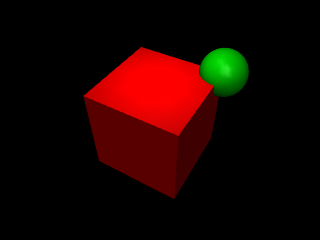

In [ ]:
try:
  del renderer  # 删除旧渲染器，确保干净环境
except:
  pass  # 忽略异常

xml = """  # 定义最初的箱体+球体模型
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)  # 从 XML 字符串创建模型
renderer = mujoco.Renderer(model)  # 初始化渲染器
data = mujoco.MjData(model)  # 初始化数据结构

mujoco.mj_forward(model, data)  # 前向计算刷新派生量
renderer.update_scene(data)  # 更新渲染场景
media.show_image(renderer.render())  # 渲染并显示

## Enable transparency and frame visualization


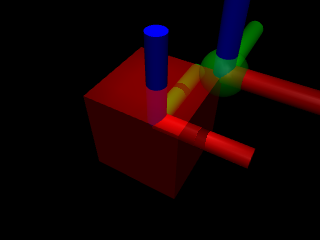

In [ ]:
scene_option = mujoco.MjvOption()  # 创建场景可视化选项
scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM  # 设置要显示的坐标系类型
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # 启用透明渲染
renderer.update_scene(data, scene_option=scene_option)  # 更新场景时应用这些选项
frame = renderer.render()  # 渲染图像
media.show_image(frame)  # 显示结果

## Depth rendering


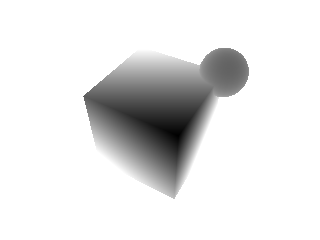

In [ ]:
# update renderer to render depth
renderer.enable_depth_rendering()  # 开启深度渲染模式

# reset the scene
renderer.update_scene(data)  # 使用当前数据更新场景

# depth is a float array, in meters.
depth = renderer.render()  # 渲染得到以米为单位的深度图

# Shift nearest values to the origin.
depth -= depth.min()  # 将最近距离平移到 0
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()  # 以近距离均值的两倍进行缩放
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)  # 限制范围并映射到 0-255

media.show_image(pixels.astype(np.uint8))  # 显示深度图

renderer.disable_depth_rendering()  # 关闭深度渲染模式

## Segmentation rendering


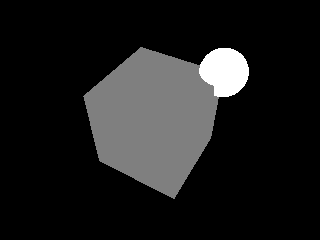

In [ ]:
# update renderer to render segmentation
renderer.enable_segmentation_rendering()  # 启用分割渲染模式

# reset the scene
renderer.update_scene(data)  # 更新场景

seg = renderer.render()  # 渲染得到包含 ID 的分割图

# Display the contents of the first channel, which contains object
# IDs. The second channel, seg[:, :, 1], contains object types.
geom_ids = seg[:, :, 0]  # 取出第一通道（对象 ID）
# Infinity is mapped to -1
geom_ids = geom_ids.astype(np.float64) + 1  # 将 -1 映射到 0，防止影响归一化
# Scale to [0, 1]
geom_ids = geom_ids / geom_ids.max()  # 归一化到 [0,1]
pixels = 255*geom_ids  # 映射到 0-255
media.show_image(pixels.astype(np.uint8))  # 显示结果

renderer.disable_segmentation_rendering()  # 关闭分割渲染模式

### The camera matrix

For a description of the camera matrix see the article [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix) on Wikipedia.

In [ ]:
def compute_camera_matrix(renderer, data):  # 根据当前渲染器/数据计算 3x4 相机矩阵
  """Returns the 3x4 camera matrix."""
  # If the camera is a 'free' camera, we get its position and orientation
  # from the scene data structure. It is a stereo camera, so we average over
  # the left and right channels. Note: we call `self.update()` in order to
  # ensure that the contents of `scene.camera` are correct.
  renderer.update_scene(data)  # 更新场景以确保相机信息最新
  pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)  # 取双目相机位置的平均值
  z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)  # 取视线方向并取反作为 z 轴
  y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)  # 取相机 up 向量
  rot = np.vstack((np.cross(y, z), y, z))  # 构造旋转矩阵的 3x3 块
  fov = model.vis.global_.fovy  # 读取垂直视场角

  # Translation matrix (4x4).
  translation = np.eye(4)  # 初始化平移矩阵
  translation[0:3, 3] = -pos  # 将相机位置编码为平移

  # Rotation matrix (4x4).
  rotation = np.eye(4)  # 初始化旋转矩阵
  rotation[0:3, 0:3] = rot  # 写入 3x3 旋转块

  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0  # 根据视场和分辨率计算焦距缩放
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]  # 构造 3x4 焦距矩阵

  # Image matrix (3x3).
  image = np.eye(3)  # 初始化图像坐标变换
  image[0, 2] = (renderer.width - 1) / 2.0  # x 轴平移到图像中心
  image[1, 2] = (renderer.height - 1) / 2.0  # y 轴平移到图像中心
  return image @ focal @ rotation @ translation  # 返回完整相机矩阵

## Project from world to camera coordinates

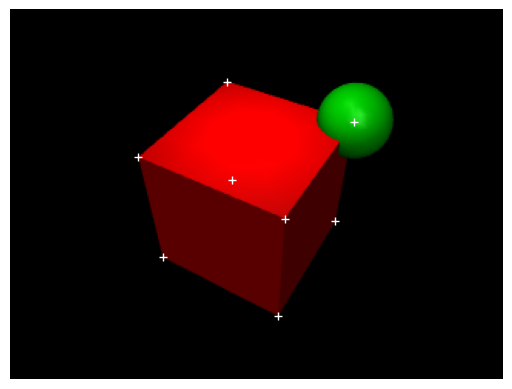

In [ ]:
# reset the scene
renderer.update_scene(data)  # 更新场景确保几何体姿态最新


# Get the world coordinates of the box corners
box_pos = data.geom_xpos[model.geom('red_box').id]  # 获取红色方块的世界坐标
box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)  # 获取姿态矩阵
box_size = model.geom_size[model.geom('red_box').id]  # 边长（半尺寸）
offsets = np.array([-1, 1]) * box_size[:, None]  # 每个轴正负半长
xyz_local = np.stack(list(itertools.product(*offsets))).T  # 组合出 8 个角的局部坐标
xyz_global = box_pos[:, None] + box_mat @ xyz_local  # 转换到世界坐标

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)  # 构造齐次坐标矩阵
corners_homogeneous[:3, :] = xyz_global  # 前三行填入 xyz

# Get the camera matrix.
m = compute_camera_matrix(renderer, data)  # 计算相机矩阵

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = m @ corners_homogeneous  # 进行齐次坐标投影
# x and y are in the pixel coordinate system.
x = xs / s  # 归一化得到像素 x
y = ys / s  # 归一化得到像素 y

# Render the camera view and overlay the projected corner coordinates.
pixels = renderer.render()  # 渲染当前视图
fig, ax = plt.subplots(1, 1)  # 创建画布
ax.imshow(pixels)  # 显示渲染图像
ax.plot(x, y, '+', c='w')  # 在图像上标记角点
ax.set_axis_off()  # 隐藏坐标轴

## Modifying the scene

Let's add some arbitrary geometry to the `mjvScene`.

In [ ]:
def get_geom_speed(model, data, geom_name):  # 计算指定 geom 的速度标量
  """Returns the speed of a geom."""
  geom_vel = np.zeros(6)  # 临时存储 6 维速度（线速度+角速度）
  geom_type = mujoco.mjtObj.mjOBJ_GEOM  # 指定对象类型为 geom
  geom_id = data.geom(geom_name).id  # 获取 geom ID
  mujoco.mj_objectVelocity(model, data, geom_type, geom_id, geom_vel, 0)  # 调用 MuJoCo API 获取速度
  return np.linalg.norm(geom_vel)  # 返回速度向量的范数

def add_visual_capsule(scene, point1, point2, radius, rgba):  # 在场景中添加可视化胶囊
  """Adds one capsule to an mjvScene."""
  if scene.ngeom >= scene.maxgeom:  # 超出上限则直接返回
    return
  scene.ngeom += 1  # increment ngeom  # 场景几何数量加一
  # initialise a new capsule, add it to the scene using mjv_makeConnector
  mujoco.mjv_initGeom(scene.geoms[scene.ngeom-1],
                      mujoco.mjtGeom.mjGEOM_CAPSULE, np.zeros(3),
                      np.zeros(3), np.zeros(9), rgba.astype(np.float32))  # 初始化胶囊几何
  mujoco.mjv_makeConnector(scene.geoms[scene.ngeom-1],
                           mujoco.mjtGeom.mjGEOM_CAPSULE, radius,
                           point1[0], point1[1], point1[2],
                           point2[0], point2[1], point2[2])  # 设置胶囊的两个端点

 # traces of time, position and speed
times = []  # 保存时间
positions = []  # 保存位置
speeds = []  # 保存速度
offset = model.jnt_axis[0]/16  # offset along the joint axis  # 沿关节轴的偏移量

def modify_scene(scn):
  """Draw position trace, speed modifies width and colors."""
  if len(positions) > 1:  # 至少有两个点才绘制轨迹
    for i in range(len(positions)-1):
      rgba=np.array((np.clip(speeds[i]/10, 0, 1),
                     np.clip(1-speeds[i]/10, 0, 1),
                     .5, 1.))  # 速度映射到颜色
      radius=.003*(1+speeds[i])  # 速度映射到宽度
      point1 = positions[i] + offset*times[i]  # 起点偏移
      point2 = positions[i+1] + offset*times[i+1]  # 终点偏移
      add_visual_capsule(scn, point1, point2, radius, rgba)  # 添加可视化胶囊

duration = 6    # (seconds)  # 轨迹持续时间
framerate = 30  # (Hz)  # 输出帧率

# Simulate and display video.
frames = []  # 存储帧

# Reset state and time.
mujoco.mj_resetData(model, data)  # 重置状态
mujoco.mj_forward(model, data)  # 前向计算，更新派生量

while data.time < duration:
  # append data to the traces
  positions.append(data.geom_xpos[data.geom("green_sphere").id].copy())  # 记录球的位置
  times.append(data.time)  # 记录时间
  speeds.append(get_geom_speed(model, data, "green_sphere"))  # 记录速度
  mujoco.mj_step(model, data)  # 推进一步
  if len(frames) < data.time * framerate:  # 根据帧率采样
    renderer.update_scene(data)  # 更新场景
    modify_scene(renderer.scene)  # 向场景添加轨迹几何
    pixels = renderer.render()  # 渲染帧
    frames.append(pixels)  # 保存帧
media.show_video(frames, fps=framerate)  # 播放结果

## Camera control

Cameras can be controlled dynamically in order to achieve cinematic effects. Run the three cells below to see the difference between rendering from a static and moving camera.

The camera-control code smoothly transitions between two trajectories, one orbiting a fixed point, the other tracking a moving object. Parameter values in the code were obtained by iterating quickly on low-res videos.

### Load the "dominos" model


In [ ]:
try:
  del renderer  # 清理旧渲染器
except:
  pass  # 无则忽略

dominos_xml = """  # 定义多米诺场景的 MJCF
<mujoco>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true" reflectance=".2"/>
  </asset>

  <statistic meansize=".01"/>

  <visual>
    <global offheight="2160" offwidth="3840"/>
    <quality offsamples="8"/>
  </visual>

  <default>
    <geom type="box" solref=".005 1"/>
    <default class="static">
      <geom rgba=".3 .5 .7 1"/>
    </default>
  </default>

  <option timestep="5e-4"/>

  <worldbody>
    <light pos=".3 -.3 .8" mode="trackcom" diffuse="1 1 1" specular=".3 .3 .3"/>
    <light pos="0 -.3 .4" mode="targetbodycom" target="box" diffuse=".8 .8 .8" specular=".3 .3 .3"/>
    <geom name="floor" type="plane" size="3 3 .01" pos="-0.025 -0.295  0" material="grid"/>
    <geom name="ramp" pos=".25 -.45 -.03" size=".04 .1 .07" euler="-30 0 0" class="static"/>
    <camera name="top" pos="-0.37 -0.78 0.49" xyaxes="0.78 -0.63 0 0.27 0.33 0.9"/>

    <body name="ball" pos=".25 -.45 .1">
      <freejoint name="ball"/>
      <geom name="ball" type="sphere" size=".02" rgba=".65 .81 .55 1"/>
    </body>

    <body pos=".26 -.3 .03" euler="0 0 -90.0">
      <freejoint/>
      <geom size=".0015 .015 .03" rgba="1 .5 .5 1"/>
    </body>

    <body pos=".26 -.27 .04" euler="0 0 -81.0">
      <freejoint/>
      <geom size=".002 .02 .04" rgba="1 1 .5 1"/>
    </body>

    <body pos=".24 -.21 .06" euler="0 0 -63.0">
      <freejoint/>
      <geom size=".003 .03 .06" rgba=".5 1 .5 1"/>
    </body>

    <body pos=".2 -.16 .08" euler="0 0 -45.0">
      <freejoint/>
      <geom size=".004 .04 .08" rgba=".5 1 1 1"/>
    </body>

    <body pos=".15 -.12 .1" euler="0 0 -27.0">
      <freejoint/>
      <geom size=".005 .05 .1" rgba=".5 .5 1 1"/>
    </body>

    <body pos=".09 -.1 .12" euler="0 0 -9.0">
      <freejoint/>
      <geom size=".006 .06 .12" rgba="1 .5 1 1"/>
    </body>

    <body name="seasaw_wrapper" pos="-.23 -.1 0" euler="0 0 30">
      <geom size=".01 .01 .015" pos="0 .05 .015" class="static"/>
      <geom size=".01 .01 .015" pos="0 -.05 .015" class="static"/>
      <geom type="cylinder" size=".01 .0175" pos="-.09 0 .0175" class="static"/>
      <body name="seasaw" pos="0 0 .03">
        <joint axis="0 1 0"/>
        <geom type="cylinder" size=".005 .039" zaxis="0 1 0" rgba=".84 .15 .33 1"/>
        <geom size=".1 .02 .005" pos="0 0 .01" rgba=".84 .15 .33 1"/>
      </body>
    </body>

    <body name="box" pos="-.3 -.14 .05501" euler="0 0 -30">
      <freejoint name="box"/>
      <geom name="box" size=".01 .01 .01" rgba=".0 .7 .79 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(dominos_xml)  # 解析 dominos 模型
data = mujoco.MjData(model)  # 初始化数据
renderer = mujoco.Renderer(model, height=1024, width=1440)  # 创建高分辨率渲染器

### Render from fixed camera

In [ ]:
duration = 2.5  # (seconds)  # 渲染 2.5 秒
framerate = 60  # (Hz)  # 60fps 输出

# Simulate and display video.
frames = []  # 帧缓存
mujoco.mj_resetData(model, data)  # Reset state and time.  # 重置状态以保证起点一致
while data.time < duration:  # 在目标时长内循环
  mujoco.mj_step(model, data)  # 推进一步
  if len(frames) < data.time * framerate:  # 控制采样频率
    renderer.update_scene(data, camera='top')  # 使用固定摄像头更新场景
    pixels = renderer.render()  # 渲染帧
    frames.append(pixels)  # 保存帧
media.show_video(frames, fps=framerate)  # 播放固定相机视频

### Render from moving camera


In [ ]:
duration = 3  # (seconds)  # 移动画面持续 3 秒

# find time when box is thrown (speed > 2cm/s)
throw_time = 0.0  # 初始化抛出时间
mujoco.mj_resetData(model, data)  # 重置状态
while data.time < duration and not throw_time:  # 模拟直到找到抛出时刻
  mujoco.mj_step(model, data)  # 推进一步
  box_speed = np.linalg.norm(data.joint('box').qvel[:3])  # 计算箱子的平移速度
  if box_speed > 0.02:  # 速度超过 2cm/s 判定为抛出
    throw_time = data.time  # 记录时间
assert throw_time > 0  # 确认找到了抛出事件

def mix(time, t0=0.0, width=1.0):
  """Sigmoidal mixing function."""
  t = (time - t0) / width  # 标准化时间
  s = 1 / (1 + np.exp(-t))  # Sigmoid 输出
  return 1 - s, s  # 返回两种权重

def unit_cos(t):
  """Unit cosine sigmoid from (0,0) to (1,1)."""
  return 0.5 - np.cos(np.pi*np.clip(t, 0, 1))/2  # 余弦形插值

def orbit_motion(t):
  """Return orbit trajectory."""
  distance = 0.9  # 环绕距离
  azimuth = 140 + 100 * unit_cos(t)  # 方位角缓慢变化
  elevation = -30  # 固定仰角
  lookat = data.geom('floor').xpos.copy()  # 观察点在地板
  return distance, azimuth, elevation, lookat

def track_motion():
  """Return box-track trajectory."""
  distance = 0.08  # 跟踪时更近
  azimuth = 280
  elevation = -10
  lookat = data.geom('box').xpos.copy()  # 看向动态 box
  return distance, azimuth, elevation, lookat

def cam_motion():
  """Return sigmoidally-mixed {orbit, box-track} trajectory."""
  d0, a0, e0, l0 = orbit_motion(data.time / throw_time)  # 归一化时间的环绕轨迹
  d1, a1, e1, l1 = track_motion()  # 跟踪轨迹
  mix_time = 0.3  # 过渡持续时间
  w0, w1 = mix(data.time, throw_time, mix_time)  # 计算混合权重
  return w0*d0+w1*d1, w0*a0+w1*a1, w0*e0+w1*e1, w0*l0+w1*l1  # 按权重混合参数

# Make a camera.
cam = mujoco.MjvCamera()  # 创建可控相机
mujoco.mjv_defaultCamera(cam)  # 初始化默认值

# Simulate and display video.
framerate = 60  # (Hz)  # 基础帧率
slowdown = 4    # 4x slow-down  # 输出时放慢 4 倍
mujoco.mj_resetData(model, data)  # 重置状态
frames = []  # 帧缓存
while data.time < duration:  # 运行模拟
  mujoco.mj_step(model, data)  # 推进一步
  if len(frames) < data.time * framerate * slowdown:  # 控制采样频率（更高）
    cam.distance, cam.azimuth, cam.elevation, cam.lookat = cam_motion()  # 更新相机姿态
    renderer.update_scene(data, cam)  # 使用自定义相机更新场景
    pixels = renderer.render()  # 渲染帧
    frames.append(pixels)  # 保存
media.show_video(frames, fps=framerate)  # 以基础帧率播放（视觉上慢动作）